This notebook is for prototyping subnetwork flow.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim
import torch.nn.functional as F
import transformer_lens.utils as tl_utils
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import GPTNeoXForCausalLM, AutoTokenizer

from pii import utils
from pii.subnet_flow.masked_model import PerTokenMaskedTransformer

# torch.set_grad_enabled(False)

### Load models

In [3]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-2.8b")
hf_model = GPTNeoXForCausalLM.from_pretrained(
    "EleutherAI/pythia-2.8b",
    low_cpu_mem_usage=True,
)

In [4]:
tl_model = HookedTransformer.from_pretrained(
    "EleutherAI/pythia-2.8b",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
with torch.no_grad():
    print(tl_model.generate("The capital of Germany is", max_new_tokens=20, temperature=0))

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-2.8b into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin, and the capital of the German state of Brandenburg is Potsdam. The capital of


In [5]:
prompt = "The capital of Germany is"

mtf_test = PerTokenMaskedTransformer(tl_model, base_prompt=prompt)
print([n for n, p in mtf_test.named_parameters() if p.requires_grad])
with torch.no_grad():
    for name, mask in mtf_test.masks.items():
        if name == "31_mlp_out" or name == "31_attn_pattern":
            print(name, mask.shape)
            continue
        mask *= 0

with torch.no_grad():
    print(
        mtf_test.tl_model.generate(
            "The capital of Germany is",
            max_new_tokens=20,
            temperature=0,
            use_past_kv_cache=False,  # This is important!
        )
    )
    mtf_test.masks_active = False
    print(
        mtf_test.tl_model.generate(
            "The capital of Germany is",
            max_new_tokens=20,
            temperature=0,
            use_past_kv_cache=False,  # This is important!
        )
    )

['masks.0_attn_z', 'masks.0_attn_pattern', 'masks.0_attn_out', 'masks.0_mlp_out', 'masks.1_attn_z', 'masks.1_attn_pattern', 'masks.1_attn_out', 'masks.1_mlp_out', 'masks.2_attn_z', 'masks.2_attn_pattern', 'masks.2_attn_out', 'masks.2_mlp_out', 'masks.3_attn_z', 'masks.3_attn_pattern', 'masks.3_attn_out', 'masks.3_mlp_out', 'masks.4_attn_z', 'masks.4_attn_pattern', 'masks.4_attn_out', 'masks.4_mlp_out', 'masks.5_attn_z', 'masks.5_attn_pattern', 'masks.5_attn_out', 'masks.5_mlp_out', 'masks.6_attn_z', 'masks.6_attn_pattern', 'masks.6_attn_out', 'masks.6_mlp_out', 'masks.7_attn_z', 'masks.7_attn_pattern', 'masks.7_attn_out', 'masks.7_mlp_out', 'masks.8_attn_z', 'masks.8_attn_pattern', 'masks.8_attn_out', 'masks.8_mlp_out', 'masks.9_attn_z', 'masks.9_attn_pattern', 'masks.9_attn_out', 'masks.9_mlp_out', 'masks.10_attn_z', 'masks.10_attn_pattern', 'masks.10_attn_out', 'masks.10_mlp_out', 'masks.11_attn_z', 'masks.11_attn_pattern', 'masks.11_attn_out', 'masks.11_mlp_out', 'masks.12_attn_z', 

  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is-nsn n n n n n n n n n n n n n n n n n


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin, and the capital of the German state of Brandenburg is Potsdam. The capital of


In [6]:
mtf_test.masks_active = True
with torch.no_grad():
    _, cache = mtf_test.tl_model.run_with_cache(
        prompt,
        remove_batch_dim=True,
    )

assert torch.allclose(cache["resid_pre", 2], cache["resid_post", 30])
assert not torch.allclose(cache["resid_pre", 2], cache["resid_post", 31])
assert torch.allclose(cache["pattern", 2], cache["pattern", 30])
assert not torch.allclose(cache["pattern", 2], cache["pattern", 31])

### Perform optimization

In [7]:
def plot_metrics(
    mtf: PerTokenMaskedTransformer,
    prompt: str,
    metric_history: list[dict[str]],
):
    print(prompt)
    utils.get_top_responses(
        prompt=prompt,
        model=mtf.tl_model,
        top_k=5,
        use_kv_cache=False,
        n_continuation_tokens=1,
    )

    df = pd.DataFrame(metric_history)

    plt.figure(figsize=(13, 2.7))
    plt.subplot(1, 3, 1)
    df.target_prob.plot()
    plt.legend()
    plt.xlabel("Step")

    plt.subplot(1, 3, 2)
    df.mask_p_norm.plot()
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Step")

    plt.subplot(1, 3, 3)
    df.mask_nonzero.plot()
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Step")

print(tl_model.to_tokens("Fact: Michael Jordan plays the sport of"))
print(tl_model.to_tokens("Fact: Michael Jordan plays the sport of basketball."))

tensor([[    0, 34182,    27,  6277, 13268,  7120,   253,  9678,   273]],
       device='cuda:0')
tensor([[    0, 34182,    27,  6277, 13268,  7120,   253,  9678,   273, 14648,
            15]], device='cuda:0')


In [9]:
prompt = "Fact: Michael Jordan plays the sport of"
mtf = PerTokenMaskedTransformer(
    tl_model,
    base_prompt=prompt,
)

print(prompt)
utils.get_top_responses(
    prompt=prompt,
    model=mtf.tl_model,
    top_k=5,
    use_kv_cache=False,
    n_continuation_tokens=1,
)

correct_str = " basketball"
correct_token = tl_model.to_tokens(correct_str)[0, 1].item()
print(correct_token)

Fact: Michael Jordan plays the sport of
Rank 0. Logit: 15.68 Prob: 69.34% Tokens: (14648) | basketball|.|
Rank 1. Logit: 13.53 Prob:  8.09% Tokens: (  521) | his| choice|
Rank 2. Logit: 12.56 Prob:  3.07% Tokens: (15692) | golf|.|
Rank 3. Logit: 11.40 Prob:  0.96% Tokens: (40751) | Basketball|.|
Rank 4. Logit: 11.36 Prob:  0.93% Tokens: (  253) | the| day|
14648


In [10]:
prompt_tokens = tl_model.to_tokens(prompt)
optim = torch.optim.Adam(
    mtf.masks.parameters(),
    lr=1e-2,
)

alpha = 20_000
n_steps = 350
p_norm = 1

metric_history: list[dict[str]] = []
pbar = tqdm(range(n_steps))
for i in pbar:
    logits = mtf.tl_model.forward(prompt_tokens, return_type="logits")[0, -1]

    target_log_prob = torch.log_softmax(logits, dim=-1)[correct_token]

    mask_p_norm = sum(
        (mask**p_norm).sum() for mask in mtf.masks.values()
    ) ** (1 / p_norm)
    mask_nonzero = sum((mask > 0).sum() for mask in mtf.masks.values())
    mask_numel = sum(mask.numel() for mask in mtf.masks.values())
    density = mask_nonzero / mask_numel
    scaled_p_norm = alpha * mask_p_norm / mask_numel

    loss = -target_log_prob + scaled_p_norm
    optim.zero_grad()
    loss.backward()
    optim.step()

    # Clamp the masks to be between 0 and 1
    with torch.no_grad():
        for mask in mtf.masks.values():
            mask.clamp_(0, 1)

    metrics = dict(
        step=i,
        loss=loss.item(),
        target_log_prob=target_log_prob.item(),
        target_prob=torch.exp(target_log_prob).item(),
        scaled_p_norm=scaled_p_norm.item(),
        mask_p_norm=mask_p_norm.item(),
        mask_nonzero=mask_nonzero.item(),
        mask_numel=mask_numel,
        density=density.item(),
    )
    metric_history.append(metrics)

    pbar.set_postfix(metrics)

  0%|          | 0/350 [00:00<?, ?it/s]

Fact: Michael Jordan plays the sport of
Rank 0. Logit: 17.06 Prob: 97.08% Tokens: (14648) | basketball| in|
Rank 1. Logit: 12.30 Prob:  0.83% Tokens: (40751) | Basketball| in|
Rank 2. Logit: 10.93 Prob:  0.21% Tokens: (24122) | athletic| A|
Rank 3. Logit: 10.56 Prob:  0.15% Tokens: (11916) | athlet| of|
Rank 4. Logit:  9.78 Prob:  0.07% Tokens: (  390) | or| in|


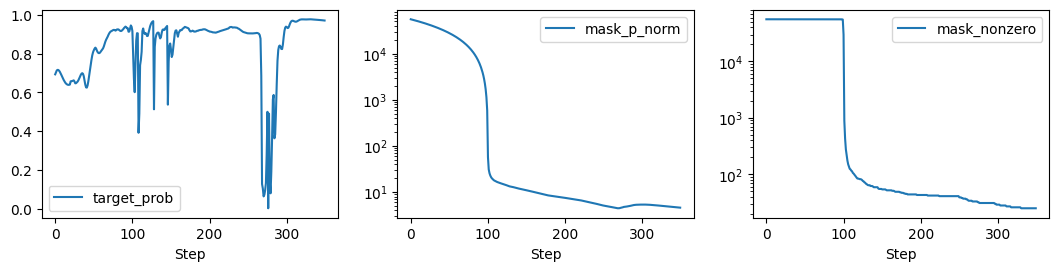

In [21]:
mtf.zero_threshold = 0
mtf.one_threshold = 1.1
plot_metrics(mtf, prompt, metric_history)

### Visualize remaining flow

In [22]:
attn_mask = np.stack(
    [mtf.masks[f"{i}_attn_out"].detach().cpu().numpy() for i in range(32)]
)
attn_z_mask = np.stack(
    [mtf.masks[f"{i}_attn_z"].detach().cpu().numpy() for i in range(32)], axis=0
)
attn_pattern_mask = np.stack(
    [mtf.masks[f"{i}_attn_pattern"].detach().cpu().numpy() for i in range(32)],
)
mlp_mask = np.stack(
    [mtf.masks[f"{i}_mlp_out"].detach().cpu().numpy() for i in range(32)]
)

attn_z_mask *= (attn_mask > 0)[:, :, np.newaxis]

attn_mask.shape, attn_z_mask.shape, attn_pattern_mask.shape, mlp_mask.shape

((32, 9), (32, 9, 32), (32, 32, 9, 9), (32, 9))

<|endoftext|>|Fact|:| Michael| Jordan| plays| the| sport| of
Layer 16, head 20, token 8: weight=0.66612333
Layer 16, head 20, token_q 8, token_k 4: weight=0.057480305
Layer 16, head 20, token_q 8, token_k 7: weight=0.662704


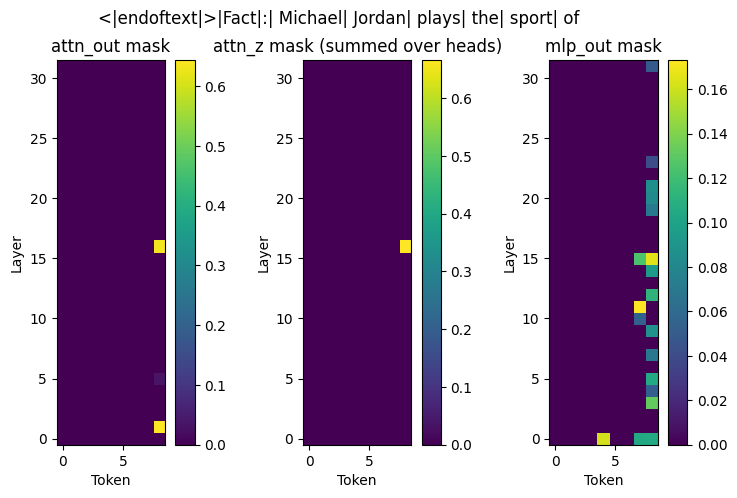

In [23]:
# Plot heatmap of attention mask
tokenized_subprompt = "|".join(
    mtf.tl_model.to_string(x)
    for x in mtf.tl_model.to_tokens(prompt)[0, mtf.mask_start_idx :]
)
print(tokenized_subprompt)

for layer_idx in range(32):
    for token_idx in range(mtf.n_tokens):
        for head_idx in range(mtf.tl_model.cfg.n_heads):
            weight = attn_z_mask[layer_idx, token_idx, head_idx]
            if weight > 0:
                print(
                    f"Layer {layer_idx},"
                    f" head {head_idx},"
                    f" token {token_idx}:"
                    f" {weight=}"
                )

for layer_idx in range(32):
    for head_idx in range(mtf.tl_model.cfg.n_heads):
        for token_idx_q in range(mtf.n_tokens):
            for token_idx_k in range(mtf.n_tokens):
                weight = attn_pattern_mask[layer_idx, head_idx, token_idx_q, token_idx_k]
                if weight > 0:
                    print(
                        f"Layer {layer_idx},"
                        f" head {head_idx},"
                        f" token_q {token_idx_q},"
                        f" token_k {token_idx_k}:"
                        f" {weight=}"
                    )

plt.figure(figsize=(9, 5))
plt.suptitle(tokenized_subprompt)

plt.subplot(1, 3, 1)
plt.imshow(attn_mask, origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("attn_out mask")

plt.subplot(1, 3, 2)
plt.imshow(attn_z_mask.sum(axis=-1), origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("attn_z mask (summed over heads)")

plt.subplot(1, 3, 3)
plt.imshow(mlp_mask, origin="lower")
plt.xlabel("Token")
plt.ylabel("Layer")
plt.colorbar()
plt.title("mlp_out mask")

plt.show()

### Analyze thresholding

In [24]:
all_mask_values = (
    torch.cat([mask.flatten() for mask in mtf.masks.values()])
    .detach()
    .cpu()
    .numpy()
)

thresholds = np.unique(
    np.sort(np.concatenate([all_mask_values, np.array([0, 1])]))
)
thresh_metrics = []
for thresh in tqdm(thresholds):
    mtf.zero_threshold = thresh
    mtf.one_threshold = 1
    with torch.no_grad():
        target_prob_0 = mtf.tl_model.forward(
            prompt_tokens, return_type="logits"
        )[0, -1].softmax(dim=0)[correct_token]

    mtf.zero_threshold = 0
    mtf.one_threshold = max(thresh, 1e-9)
    with torch.no_grad():
        target_prob_1 = mtf.tl_model.forward(
            prompt_tokens, return_type="logits"
        )[0, -1].softmax(dim=0)[correct_token]

    thresh_metrics.append(
        dict(
            threshold=thresh,
            target_prob_0=target_prob_0.item(),
            target_prob_1=target_prob_1.item(),
            n_nonzero=(all_mask_values > thresh).sum(),
            n_ones=(all_mask_values > thresh).sum(),
        )
    )

  0%|          | 0/27 [00:00<?, ?it/s]

# nonzero mask values: 25
# total mask values: 92736


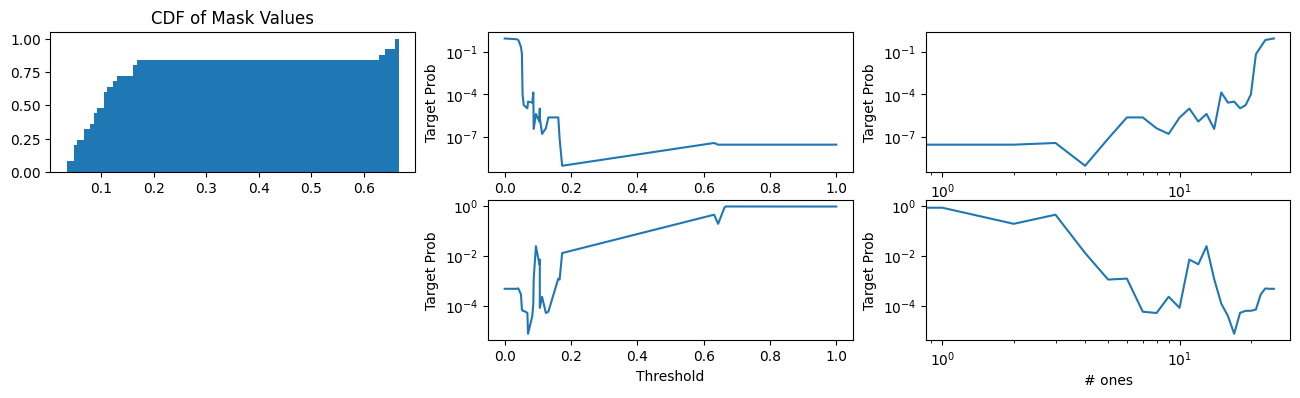

In [25]:
df_thresh = pd.DataFrame(thresh_metrics)

print("# nonzero mask values:", (all_mask_values > 0).sum())
print("# total mask values:", all_mask_values.size)

plt.figure(figsize=(16, 4))
plt.subplot(2, 3, 1)
plt.hist(
    all_mask_values[all_mask_values > 0],
    cumulative=True,
    bins=100,
    density=True,
)
plt.title("CDF of Mask Values")

plt.subplot(2, 3, 2)
plt.plot(df_thresh.threshold, df_thresh.target_prob_0)
plt.yscale("log")
plt.xlabel("0 Threshold")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 3)
plt.plot(df_thresh.n_nonzero, df_thresh.target_prob_0)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# non-zero mask values")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 5)
plt.plot(df_thresh.threshold, df_thresh.target_prob_1)
plt.yscale("log")
plt.xlabel("Threshold")
plt.ylabel("Target Prob")

plt.subplot(2, 3, 6)
plt.plot(df_thresh.n_ones, df_thresh.target_prob_1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# ones")
plt.ylabel("Target Prob")
plt.show()